# Setup

In [1]:
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import warnings
import os
import pandas as pd
import anndata as ad
import seaborn as sns

Global seed set to 0


In [2]:
sc.set_figure_params(figsize=(4,4),  dpi=150, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.getcwd()

'/notebook/Joe/M-cells/code/epithelial_signature_processing'

# Data import

Data from: https://www.sciencedirect.com/science/article/pii/S258900422031035X <br>
Accession link: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE150327 <br>
GSE150327_RAW.tar - using only GSM4546898_Adult_filtered_feature_bc_matrix.h5 <br>
Annotated data for cell types: https://figshare.com/articles/dataset/Postnatal_SMG_Integrated_rds/13157726 <br>

In [4]:
adata = sc.read_10x_h5("/notebook/External/Archive/Joe/raw_data/epithelial_atlases/postnatal_salivary_gland/GSM4546898_Adult_filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
adata.obs.index = [i[0] for i in adata.obs.index.str.split("-")]

/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
processedAdata = sc.read("/notebook/External/Archive/Joe/raw_data/epithelial_atlases/postnatal_salivary_gland/postnatal_smg_integrated.h5ad")
processedAdata = processedAdata[processedAdata.obs.stage == "Adult"]
processedAdata.obs.index = [i[0] for i in processedAdata.obs.index.str.split("-")]

In [6]:
adata = adata[processedAdata.obs.index]
adata.obs = adata.obs.join(processedAdata.obs, how="inner")
adata.obs["batch"] = adata.obs["sample"]
adata.obs["cell_type"] = [i[1] for i in adata.obs["celltype.stage"].str.split("_")]
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.9,seurat_clusters,stage,CellType,sample,sex,integrated_snn_res.0.9,celltype.stage,celltype.stage.sex,integrated_snn_res.0.6,celltype.fixed,subpopulations,batch,cell_type
AAACCTGAGAAGGACA,SeuratProject,2777.0,1206,1.800504,NA,0,Adult,15,S3,Female,0,Adult_Smgc+,Adult_Female_Smgc+,0,8,5,S3,Smgc+
AAACCTGAGATGTGTA,SeuratProject,1198.0,637,3.088481,NA,0,Adult,15,S3,Female,0,Adult_Smgc+,Adult_Female_Smgc+,0,8,5,S3,Smgc+
AAACCTGAGGTGACCA,SeuratProject,2022.0,1023,2.324431,NA,5,Adult,8,S3,Female,6,Adult_Intercalated duct,Adult_Female_Intercalated duct,5,10,6,S3,Intercalated duct
AAACCTGCAATAGCAA,SeuratProject,2882.0,221,4.718945,NA,1,Adult,0,S3,Female,1,Adult_Acinar,Adult_Female_Acinar,1,7,2,S3,Acinar
AAACCTGCAATGAAAC,SeuratProject,43664.0,1466,0.462624,NA,2,Adult,0,S3,Female,2,Adult_Acinar,Adult_Female_Acinar,2,7,0,S3,Acinar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTTCCATGA,SeuratProject,650.0,269,7.076923,NA,0,Adult,15,S3,Female,0,Adult_Smgc+,Adult_Female_Smgc+,0,7,2,S3,Smgc+
TTTGTCAAGGCTCATT,SeuratProject,1973.0,747,3.142423,NA,0,Adult,15,S3,Female,0,Adult_Smgc+,Adult_Female_Smgc+,0,8,5,S3,Smgc+
TTTGTCAAGTGTTAGA,SeuratProject,4206.0,1862,3.447456,NA,10,Adult,1,S3,Female,12,Adult_Ascl3+ duct,Adult_Female_Ascl3+ duct,10,10,6,S3,Ascl3+ duct
TTTGTCACATCCTAGA,SeuratProject,2343.0,1024,2.731541,NA,0,Adult,3,S3,Female,16,Adult_Bpifa2+,Adult_Female_Bpifa2+,0,6,4,S3,Bpifa2+


# Process data

In [7]:
# Helper method for plotting QC metrics for scrnaseq package
def qc_plot(adata, counts_thresh=30000, genes_thresh=5000, mt_thresh=10, show_thresh=True):
    sns.set_style("ticks")
    sns.set_context("paper")
    fig=plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    sns.histplot(
        x=adata.obs.pct_counts_mt,
        hue=adata.obs.batch,
    )
    if show_thresh:
        plt.axvline(
            x=mt_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )

    plt.subplot(1,3,2)
    sns.scatterplot(
        x=adata.obs.total_counts,
        y=adata.obs.n_genes_by_counts,
        s=2,
        hue=adata.obs.batch,
        linewidth=0,
    )
    if show_thresh:
        plt.axvline(
            x=counts_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )
        plt.axhline(
            y=genes_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    plt.subplot(1,3,3)
    cell_data = pd.DataFrame()
    for category in adata.obs.batch.unique():
        category_data = adata[adata.obs.batch == category].obs.copy()
        category_data["rank"] = category_data.total_counts.rank(method="first", ascending=False,)
        cell_data = pd.concat([cell_data, category_data])
    cell_data = cell_data.sort_values(by="rank")
    sns.lineplot(
        x=cell_data["rank"],
        y=cell_data.total_counts,
        hue=cell_data.batch,
        hue_order=adata.obs.batch.unique(),
    )
    if show_thresh:
        plt.axhline(
            y=counts_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    fig.tight_layout()
    plt.show()

## Full Atlas

In [8]:
adata.layers["counts"] = adata.X.copy()
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

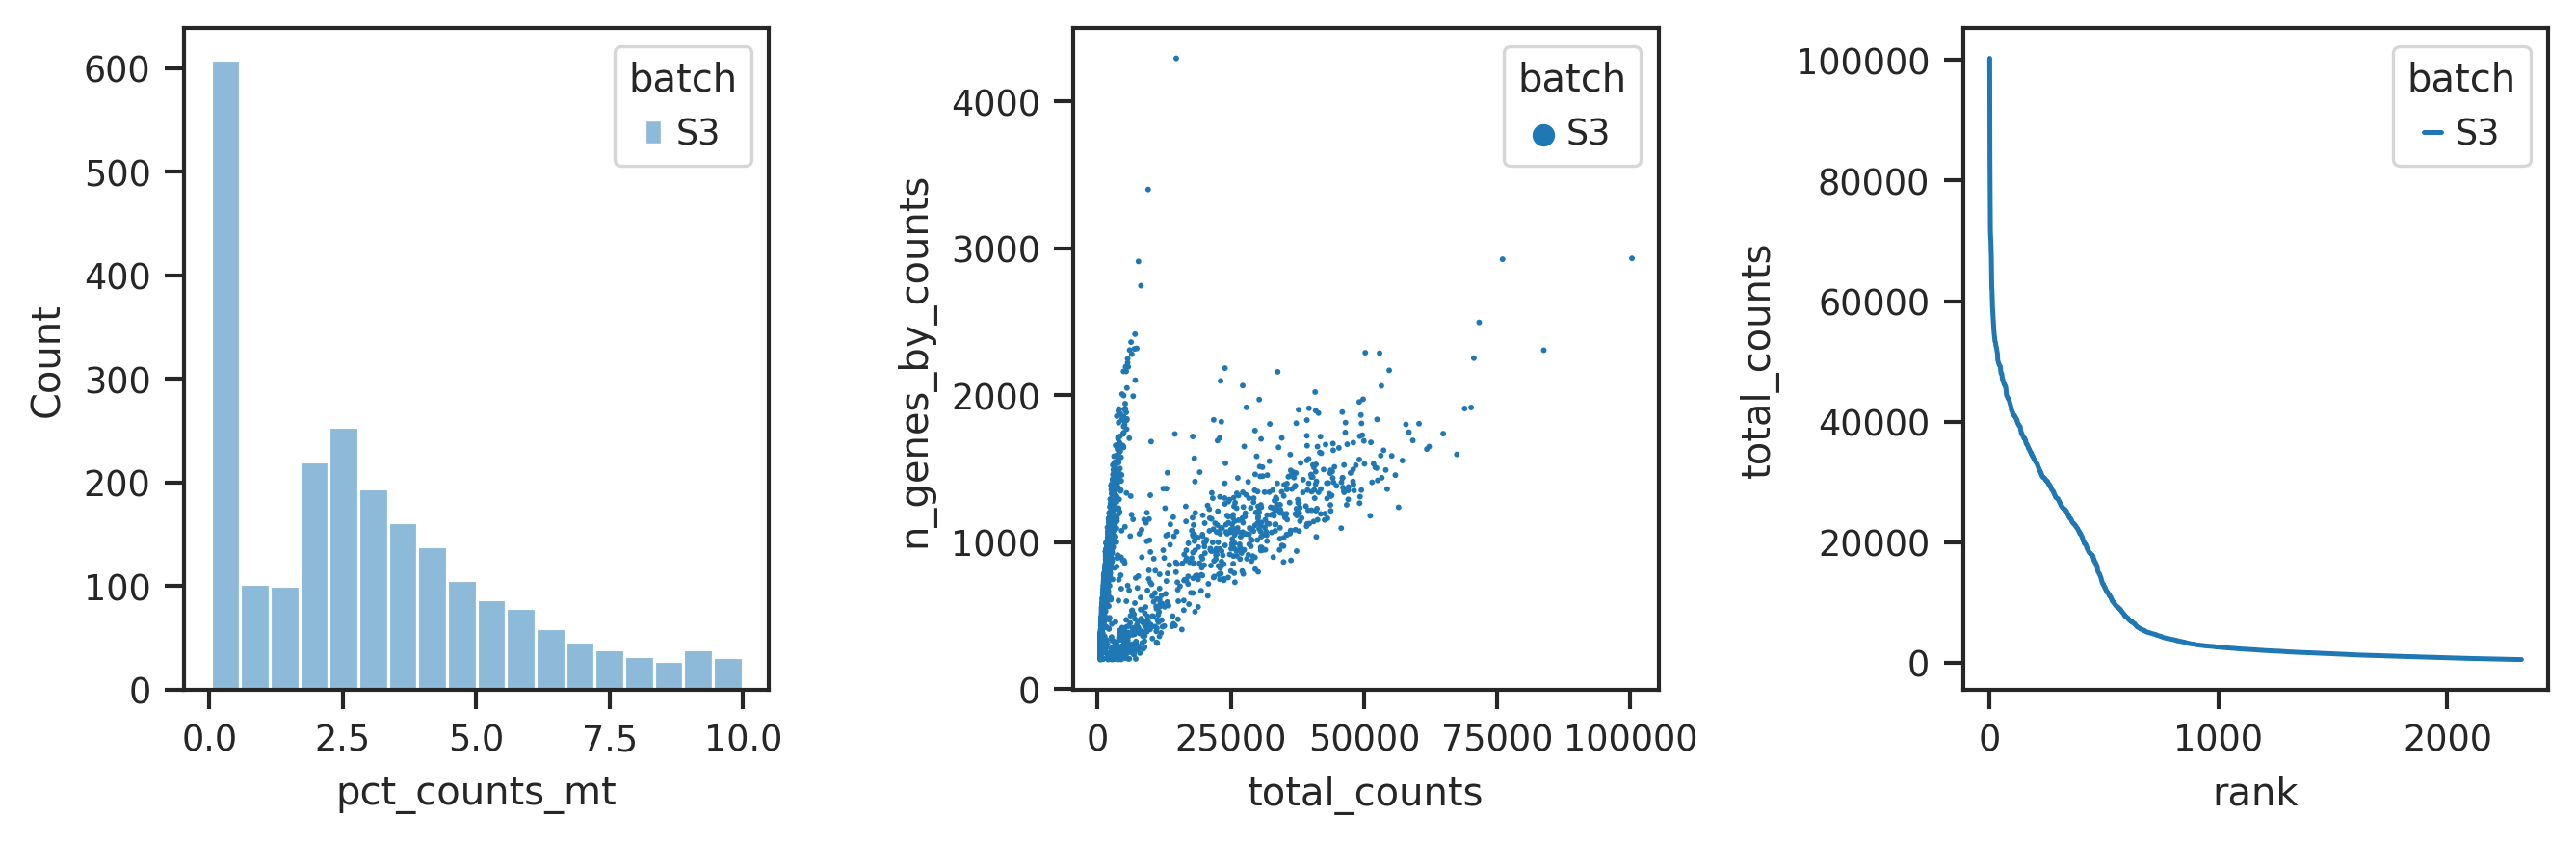

In [9]:
qc_plot(adata, show_thresh=False)

# Create pseudobulk signatures

In [10]:
def create_signature_matrix(adata, obs_key, save_path):
    signatures = pd.DataFrame(index=adata.var_names)
    for cell_type in adata.obs[obs_key].unique():
        signatures[cell_type] = list(pd.DataFrame(adata[adata.obs[obs_key] == cell_type].X.todense()).mean(axis=0))
    signatures.to_csv(save_path)
    return signatures

## Full atlas

In [20]:
signatures = create_signature_matrix(adata, "cell_type", "/notebook/Joe/M-cells/analysis/cell_type_signatures/salivary_gland_epithelium_signatures.csv")

In [21]:
signatures

,Smgc+,Intercalated duct,Acinar,Bpifa2+,Basal duct,Striated duct,Macrophages,Myoepithelial,GCT,Endothelial,Ascl3+ duct,NK cells,Stromal,Erythroid
4933401J01Rik,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm26206,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Xkr4,0.0,0.007923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm18956,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm37180,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tg_RenLucif,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tg_FflyLucif,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tg_hspCas9,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tg_Tet-resTA,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
signatures = signatures.drop(["Macrophages", "Endothelial", "NK cells", "Stromal", "Erythroid"], axis=1)
signatures.columns = [i.replace(" ", ".") for i in signatures.columns]
signatures.columns = signatures.columns + "_salivary_gland"
signatures

,Smgc+_salivary_gland,Intercalated.duct_salivary_gland,Acinar_salivary_gland,Bpifa2+_salivary_gland,Basal.duct_salivary_gland,Striated.duct_salivary_gland,Myoepithelial_salivary_gland,GCT_salivary_gland,Ascl3+.duct_salivary_gland
4933401J01Rik,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm26206,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Xkr4,0.0,0.007923,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm18956,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm37180,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
tg_RenLucif,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tg_FflyLucif,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tg_hspCas9,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tg_Tet-resTA,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
signatures.to_csv("/notebook/Joe/M-cells/analysis/cell_type_signatures/salivary_gland_epithelium_signatures.csv")